# Modelagem de tópicos com dados do Diário Oficial do Recife

Neste notebook, construiremos um modelo de tópico usando o LdaModel da biblioteca Gensim e visualizaremos os resultados com ajuda da biblioteca Plotly.

## Importar bibliotecas



In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('portuguese')
stop_words.extend(['janeiro','fevereiro','março','abril','maio','junho','julho','agosto','setembro','outubro','novembro','dezembro','recife'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Importar o dataset

Utilizaremos a biblioteca Pandas para importar o arquivo "dore_2009_proc.csv", uma coleção de documentos extraídos do Diário Oficial do Recife. 

In [2]:
# Import Dataset
dataset = pd.read_csv("dore_2009_proc.csv")
dsecao = dataset["secao"]
dtext = dataset["conteudo"]
dlabel = dataset["int_label"]
print(dsecao)
print(dtext)  
print(dlabel)

0               Poder Executivo
1               Poder Executivo
2               Poder Executivo
3               Poder Executivo
4               Poder Executivo
                 ...           
5139    Poder Legislativo - old
5140                   Notícias
5141                   Notícias
5142                   Notícias
5143                   Notícias
Name: secao, Length: 5144, dtype: object
0       LEI Nº 17.597 /2009  EMENTA: DISPÕE SOBRE A SE...
1       DECRETO Nº 25.024 DE 30 DE DEZEMBRODE 2009  EM...
2       PORTARIA Nº 3130 DE 30 DE DEZEMBRO DE  2009  O...
3       º 18012078.    PORTARIA Nº 3137 DE 30 DE DEZEM...
4       esenvolvimento Urbano e Ambiental, a contar da...
                              ...                        
5139     dias do mês de novembro do ano corrente. E eu...
5140    Opresidente da República, Luiz Inácio Lula da ...
5141    O prefeito João Paulo anunciou, na última quar...
5142    Em um dos seus últimos atos à frente da gestão...
5143    Na última quarta-fe

## Limpar e preparar os dados

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = dtext
data_words = list(sent_to_words(data))
print(data_words[:1])

[['lei', 'nº', 'ementa', 'dispoe', 'sobre', 'semana', 'municipal', 'de', 'cultura', 'evangelica', 'da', 'outras', 'providencias', 'faco', 'saber', 'que', 'poder', 'legislativo', 'do', 'municipio', 'rejeitou', 'veto', 'total', 'ao', 'projeto', 'de', 'lei', 'nº', 'do', 'poder', 'legislativo', 'eu', 'prefeito', 'da', 'cidade', 'do', 'recife', 'nos', 'termos', 'do', 'art', 'da', 'lei', 'organica', 'do', 'municipio', 'promulgo', 'seguinte', 'lei', 'art', 'fica', 'instituida', 'semana', 'municipal', 'de', 'cultura', 'evangelica', 'no', 'municipio', 'do', 'recife', 'paragrafo', 'unico', 'as', 'comemoracoes', 'ocorrerao', 'entre', 'os', 'dias', 'seis', 'doze', 'de', 'dezembro', 'art', 'tema', 'reflexoes', 'de', 'que', 'tratam', 'paragrafo', 'unico', 'entre', 'outros', 'abordarao', 'temas', 'como', 'educacao', 'religiosa', 'mercado', 'de', 'trabalho', 'saude', 'auto', 'estima', 'crianca', 'adolescente', 'relacao', 'com', 'sociedade', 'historia', 'luta', 'da', 'igreja', 'evangelica', 'liderancas

## Build the Bigram, Trigram Models and Lemmatize

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('pt_core_news_sm')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Encontrando a quantidade ideal de clusters (neste caso tópicos)

Utilizaremos o TfidfVectorizer do Sklearn para a extração de palavras-chave, elas serão utilizadas para formar os clusters. Em seguida, calculamos o Sum of Squared Error (SSE) para vários tamanhos de cluster, neste caso até 14, e depois procuramos o "cotovelo" onde o SSE começa a se estabilizar. 

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


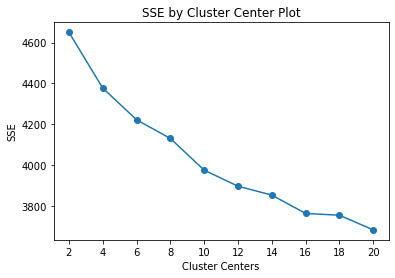

In [5]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = stop_words
)
tfidf.fit(dtext)
text = tfidf.transform(dtext)

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

## Construindo o modelo de tópico

Para criar o modelo de tópico LDA usando LdaModel(), precisamos do corpus e do dicionário. Primeiro iremos criá-los e depois construiremos o modelo. Os tópicos treinados (palavras-chave e pesos) também são impressos abaixo.

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.000*"dedezembro" + 0.000*"esculturar" + 0.000*"sofin_ct" + 0.000*"tc" + '
  '0.000*"refeitura" + 0.000*"poesia" + 0.000*"encomendar" + 0.000*"basante" + '
  '0.000*"dilma" + 0.000*"criatividade"'),
 (1,
  '0.000*"dedezembro" + 0.000*"esculturar" + 0.000*"sofin_ct" + 0.000*"tc" + '
  '0.000*"refeitura" + 0.000*"poesia" + 0.000*"encomendar" + 0.000*"basante" + '
  '0.000*"dilma" + 0.000*"criatividade"'),
 (2,
  '0.147*"nº" + 0.065*"educacao" + 0.054*"secretariar" + 0.052*"publicacao" + '
  '0.049*"visto" + 0.044*"lotacao" + 0.035*"centrar" + 0.033*"professor" + '
  '0.030*"codigo" + 0.028*"considerar"'),
 (3,
  '0.073*"nº" + 0.039*"ter" + 0.027*"contratar" + 0.024*"prazo" + '
  '0.021*"servicos" + 0.019*"cidade" + 0.018*"dia" + 0.017*"valor" + '
  '0.017*"empresar" + 0.015*"processar"'),
 (4,
  '0.194*"nº" + 0.068*"assistente" + 0.065*"simbolo" + 0.059*"comissao" + '
  '0.043*"conter" + 0.041*"contar" + 0.039*"portar" + 0.039*"prefeito" + '
  '0.037*"secretariar" + 0.035*"cargo

## Tópicos dominante e porcentagem de contribuição em cada documento

Nos modelos de LDA, cada documento é composto de vários tópicos. Mas, normalmente, apenas um dos tópicos é o dominante. O código abaixo extrai esse tópico dominante para cada documento e mostra o peso do tópico e das palavras-chave em uma tabela.

In [7]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(682)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             7.0              0.6215   
1              1             5.0              0.8014   
2              2             4.0              0.6646   
3              3             4.0              0.7539   
4              4             4.0              0.8739   
..           ...             ...                 ...   
677          677             3.0              0.8044   
678          678             3.0              0.3676   
679          679             4.0              0.3348   
680          680             3.0              0.3336   
681          681             3.0              0.8544   

                                              Keywords  \
0    comissionar, parlamentar, vereador, presidente...   
1    municipal, resolucao, artigo, assistencia, dis...   
2    nº, assistente, simbolo, comissao, conter, con...   
3    nº, assistente, simbolo, comissao, conter, con...   
4    nº, assistente, simbolo, comissao, conter, con...   
..                                                 ...   
677  nº, ter, contratar, prazo, servicos, cidade, d...   
678  nº, ter, contratar, prazo, servicos, cidade, d...   
679  nº, assistente, simbolo, comissao, conter, con...   
680  nº, ter, contratar, prazo, servicos, cidade, d...   
681  nº, ter, contratar, prazo, servicos, cidade, d...   

                                                  Text  
0    [lei, nº, ementar, dispoe_sobre, semana, cultu...  
1    [decretar, nº, dezembrode, prefeito, cidade, c...  
2    [portar, nº, prefeito, conter, portar, nº, sec...  
3    [portar, nº, prefeito, conter, oficiar, nº, nº...  
4    [esenvolvimento, contar, datar, nº, prefeito, ...  
..                                                 ...  
677  [fundacao, cultura, cidade, extrato, atar, nº,...  
678  [portar, nº, secretariar, educacao, acordar, d...  
679  [assistencia, social, nº, diretora, presidente...  
680  [financas, administracao, tributar, gerencia, ...  
681  [autarquia, saneamento, sanear, ter, aditivo, ...  

[682 rows x 5 columns]

## Word Clouds com as principais palavras-chave em cada tópico

Word Clouds em que o tamanho das palavras é proporcional ao peso delas em cada tópico.

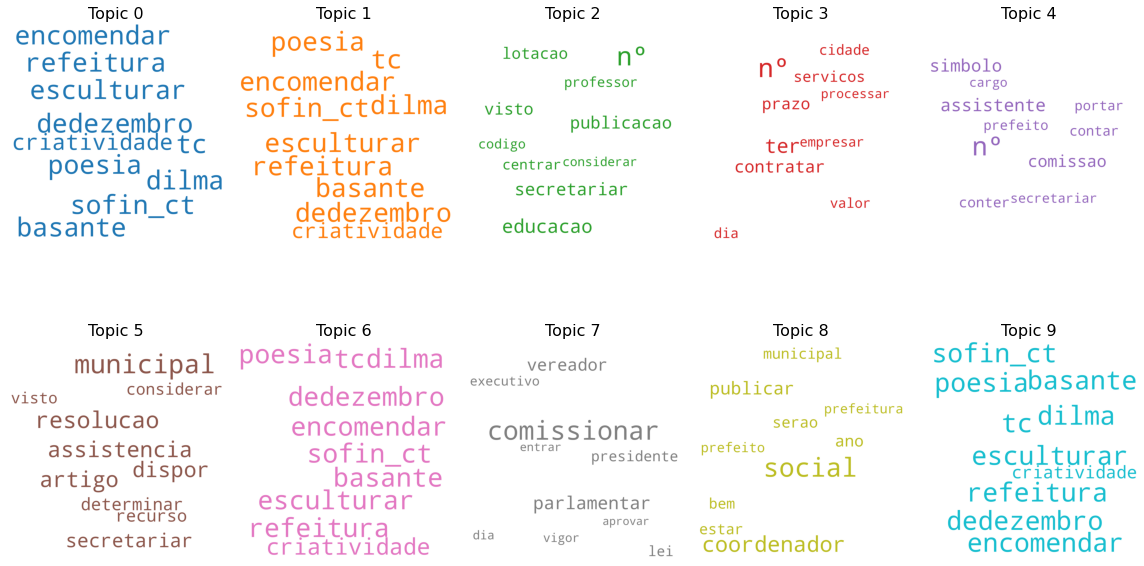

In [8]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## T-SNE Clustering

Agora visualizaremos os clusters de cada tópico em um espaço 2D usando o algoritmo t-SNE (t-distributed stochastic neighbor embedding) e a biblioteca Plotly.

In [9]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5144 samples in 0.012s...
[t-SNE] Computed neighbors for 5144 samples in 0.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5144
[t-SNE] Computed conditional probabilities for sample 2000 / 5144
[t-SNE] Computed conditional probabilities for sample 3000 / 5144
[t-SNE] Computed conditional probabilities for sample 4000 / 5144
[t-SNE] Computed conditional probabilities for sample 5000 / 5144
[t-SNE] Computed conditional probabilities for sample 5144 / 5144
[t-SNE] Mean sigma: 0.042870
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.874298
[t-SNE] KL divergence after 1000 iterations: 0.985844


### Layout 1

In [12]:
import plotly.express as px

n_topics = 20
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

fig1 = px.scatter(dtext, x=tsne_lda[:,0], y=tsne_lda[:,1], hover_data=[keywords["Dominant_Topic"]], labels={'hover_data_0':'Dominant Topic'})
fig1.show()

#, color=mycolors[]

### Layout 2

In [14]:
array_dominant_topic = np.array(keywords["Dominant_Topic"].values.tolist())

array_dominant_topic = array_dominant_topic.astype(int)

import plotly.express as px

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

fig1 = px.scatter(dtext, x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[array_dominant_topic],  hover_data=[keywords["Dominant_Topic"]], labels={'hover_data_0':'Dominant Topic'})
fig1.show()

### Layout 3

In [15]:
fig1 = px.scatter(dtext, x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[array_dominant_topic],  hover_data=[dlabel], labels={'hover_data_0':'Label'})
fig1.show()